# Lecture 4: Multilayer Perceptions (II)

 **Reading**:   Chapter 4.6, 4.7 and 4.10 of *Dive Into Deep Learning*

## Outline

* Dropout
* Forward Propogation, Backward Propogation and Computational Graph
* Predicting House Prices in Kaggle




# Dropout

- *Weight Decay*: classical approach to regularizing statistical models by penalizing the $L_2$ norm of the weights.
  - Encourage the model to spread out its weights among many features
  - Increase the robustness against measurement noises of the input features
  - Restrict the set of possible values for model paramters
- This section introduce another popular regularisation method

## Overfitting Revisited

- *Overfitting of lineare models*: more features than examples.
  - With more examples, overfitting is not a more problem in general.  
- Linear models are very limited. 
- Nonlinear models are more flexible but more prone to overfitting

- *bias-variance tradeoff*: Balance between  generalizability and flexibility
  - Linear models have high bias: they can only represent a small class of functions.
  - Linear models have low variance: they give similar results across different random samples of the data.
  - Neural networks are universal function approximators
   - Even we have far examples than input features, they are  capable of overfitting.
   - They learn large number of nonlinear features.
   

## Robustness through Perturbations
  
- Classical generalization theory suggests simpler mdoels generalize better
- Measures of simplicity 
  - Number of dimension, number of parameters
  - Norm of the parameters: weight decay regualrisation
  - **Smoothness**: that the function should not be sensitive to small changes to its inputs.

- Drop out: injecting noise while computing each internal layer during training
  - *Drop out* some neurons during training.
  - Inject the noise in an *unbiased* manner so that the expected value of each layer does not change

-  *dropout probability* $p$: for each intermediate activation $h$ is replaced by a random variable $h'$ as:
$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}
$$

-  By design, the expectation remains unchanged, i.e., $E[h'] = h$.

## Dropout in Practice

- When we apply dropout to a hidden layer, zeroing out each hidden unit with probability $p$,
- The result can be viewed as a network containing only a subset of the original neurons.

![MLP before and after dropout.](../img/dropout2.svg)


-  Dropout is disabled at test time.

## Concise Implementation

- Add a `Dropout` layer after each fully-connected layer,
  - passing in the dropout probability as the only argument to its constructor.

- During training, the `Dropout` layer will randomly drop out outputs of the previous layer


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

### Train and test the model


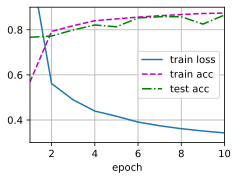

In [3]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Summary of Dropout

* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often they are used jointly.
* Dropout replaces an activation $h$ with a random variable with expected value $h$.
* Dropout is only used during training.



# Forward Propagation, Backward Propagation, and Computational Graphs

## Forward Propagation

- *Forward propagation*:  calculation and storage of intermediate variables in the hidden layers and the outputs
  - Order: from the input layer to the output layer.

- Input ($\mathbf{x}\in \mathbb{R}^d$): a list of $d$ scalar numbers
- The intermediate variable in the first hidden layer:
$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x}$$
  - $\mathbf{z}$: a list of $h$ scalar numbers
  - $\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$: transformation matrix (a list of $h$ row vectors of dimension $d$)
  - $\mathbf{W}^{(1)}$: the weight parameter of the hidden layer.
- Activation function $\phi$
$$\mathbf{h}= \phi (\mathbf{z}).$$

- Output: 
$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

- Loss term for a single data example,

$$L = l(\mathbf{o}, y).$$
   - $l$ loss function, e.g. squared loss
   - $y$: label 

-  $L_2$ regularization, 
$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right),$$
  - $\lambda$: regularisation number
  - $|\mathbf{W}\|_F^2$: sum of all the elements in a matrix $W$


- Overall loss function

$$J = L + s.$$

## Computational Graph of Forward Propagation


![Computational graph of forward propagation.](../img/forward.svg)

## Backpropagation

- *Backpropagation*: calculating the gradient of neural network parameters.
  - The method traverses the network in reverse order, from the output to the input layer
  - Using the *chain rule* from calculus.
- The algorithm stores the partial derivatives of any intermediate variables and any model parameters

- Automatic differentiation 
  - Given any model parameters of the network and any set of input examples, the BP algorithm compute all the partial dirivatives of the loss function with respect to model parameters and the intermediate variables in the hidden layers.
  - The computation is similar to forward propogation. 

## Training Neural Networks

- In training, forward and backward propagation depend on each other.
- Forward propagation traverses the computational graph in the direction of dependencies and compute all the variables on its path.
  - These are then used for backpropagation.
  

- After backprogation, the model parameters are updated with a learning rate, and then
- The next iteration starts with forward propogation 
- After model parameters are initialized, we alternate forward propagation with backpropagation, updating model parameters using gradients given by backpropagation.

## Summary 

* Forward propagation sequentially calculates and stores intermediate variables from the input to the output layer.
* Backpropagation sequentially calculates and stores the gradients of intermediate variables in the reversed order.
* When training deep learning models, forward propagation and back propagation are interdependent.
* Training requires significantly more memory than prediction.


# Predicting House Prices on Kaggle

- Data preprocessing, model design, and hyperparameter selection.

## Downloading and Caching Datasets



In [4]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

## `download` function


In [5]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [6]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

## Kaggle

- A popular platform that hosts machine learning competitions.

- House price prediction competition page

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques



## Accessing and Reading the Dataset

- The competition data is separated into training and test sets.
- Each record includes the property value of the house and attributes such as street type, year of construction, roof type, basement condition, etc.
- Data types: integer (e.g. the year of construction), categorical and floating point numbers
- Some data are missing with the missing value marked simply as "na".



In [7]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

For convenience, we can download and cache
the Kaggle housing dataset
using the script we defined above.


In [8]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

We use `pandas` to load the two csv files containing training and test data respectively.


In [9]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

The training dataset includes 1460 examples,
80 features, and 1 label, while the test data
contains 1459 examples and 80 features.


In [10]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


- A few examples

In [11]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


- Remove the ID from the dataset model.


In [12]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocessing

- **replacing all missing values by the corresponding feature's mean.**
- **Standardize** the data by rescaling features to zero mean and unit variance:

$$x \leftarrow \frac{x - \mu}{\sigma},$$

 -  $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
 

In [13]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

- **Deal with discrete values.**
  - **Replace them by a one-hot encoding**)


In [14]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

- Dimenson change: the conversion increases the number of features from 79 to 331.
Finally, via the `values` attribute,
- **Extract the NumPy format from the `pandas` format and convert it into the tensor**


In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## **Training**

- Starts with  a linear model with squared loss.



In [16]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

- Loss function 
  - Relative quantities vs  absolute quantities
  - **Measure the discrepancy in the logarithm of the price estimates.**

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [17]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

##  Adam optimizer
- Less sensitive to the initial learning rate.


In [18]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$-Fold Cross-Validation



In [19]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

### Train $K$ times in the $K$-fold cross-validation and return the average performance


In [20]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## **Model Selection**




fold 1, train log rmse 0.170913, valid log rmse 0.156706
fold 2, train log rmse 0.162393, valid log rmse 0.191553
fold 3, train log rmse 0.163761, valid log rmse 0.168429
fold 4, train log rmse 0.168663, valid log rmse 0.154676
fold 5, train log rmse 0.163244, valid log rmse 0.183080
5-fold validation: avg train log rmse: 0.165795, avg valid log rmse: 0.170889


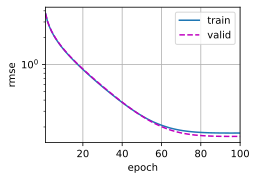

In [21]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')



##   Predictions



In [22]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162235


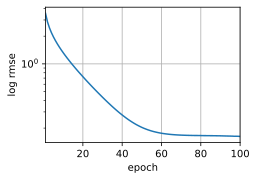

In [23]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)